<a href="https://colab.research.google.com/github/tlacaelel666/projectalpha1/blob/main/Simulador_de_Lindblad_extendido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Simulador Robusto de Ecuación de Lindblad ===

1. Simulando qubit con relajación T1...
   ✓ Simulación exitosa (56 evaluaciones)


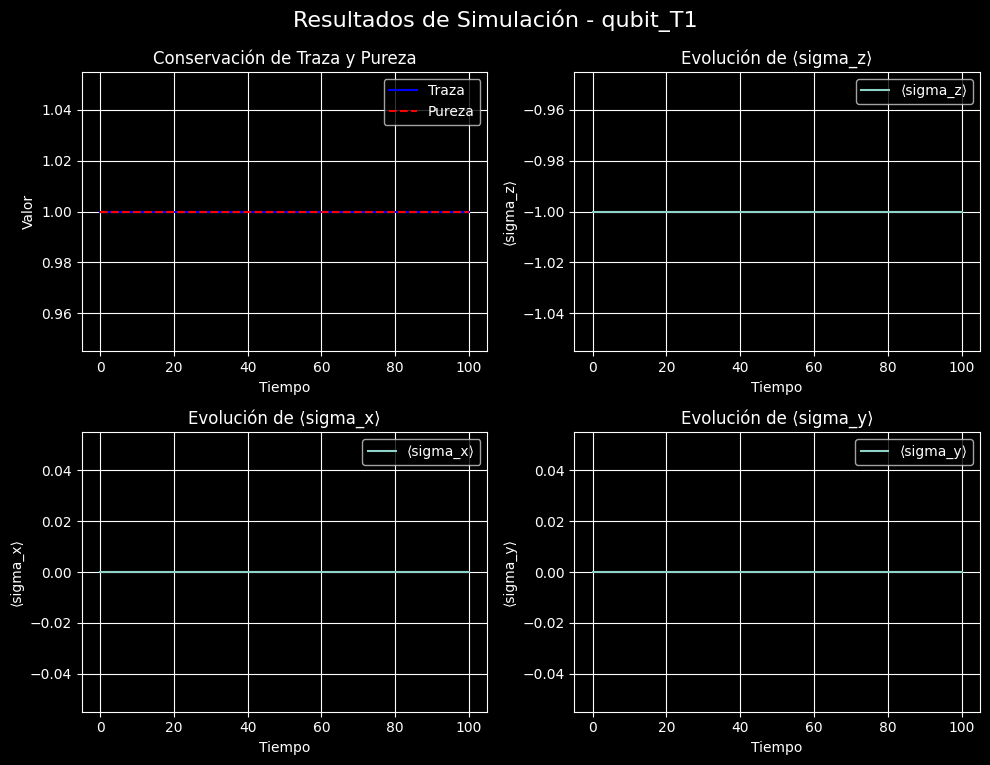


2. Simulando oscilador armónico con dephasing...
   ✓ Simulación exitosa (506 evaluaciones)


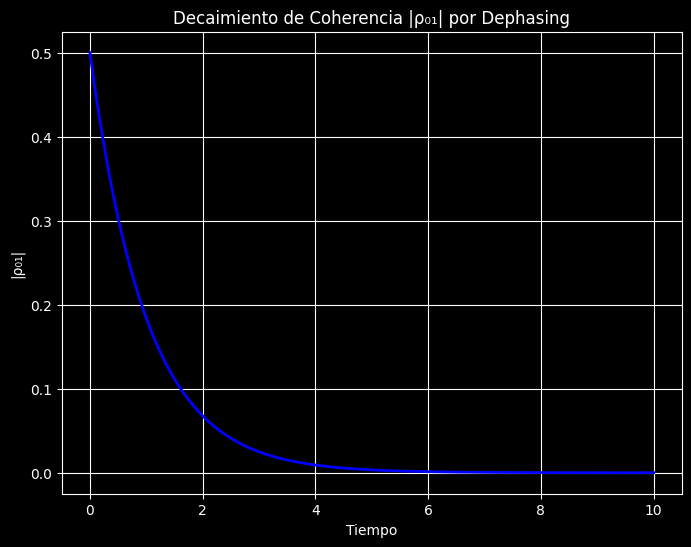

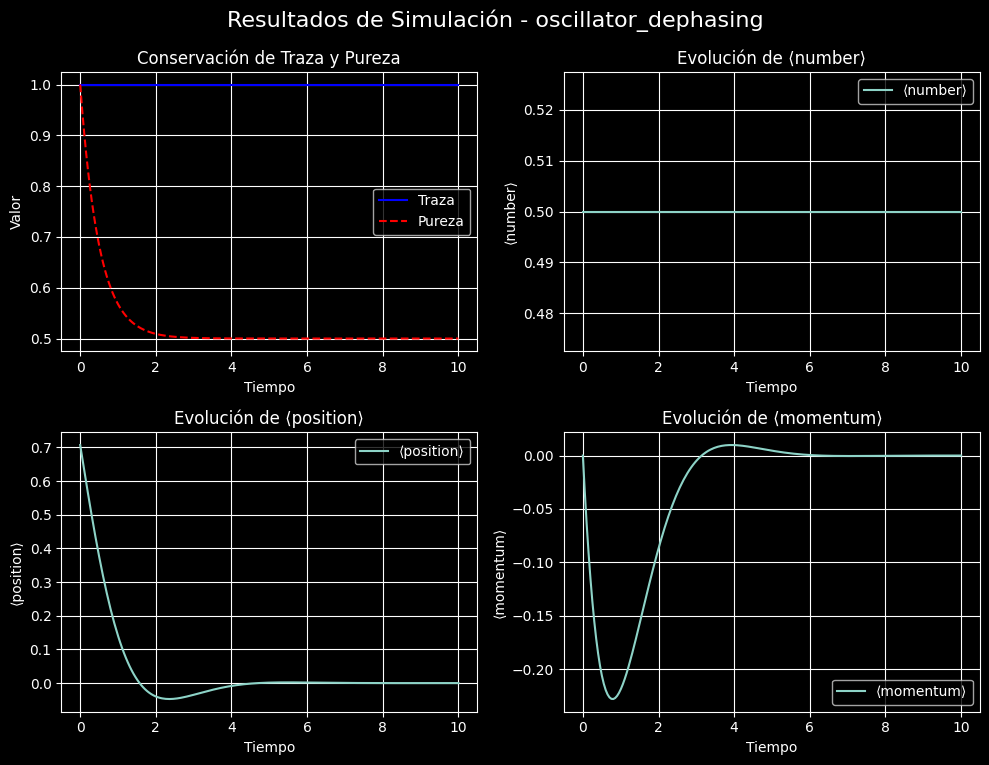


3. Simulando decaimiento de Tritio...
   ✓ Simulación exitosa (140 evaluaciones)


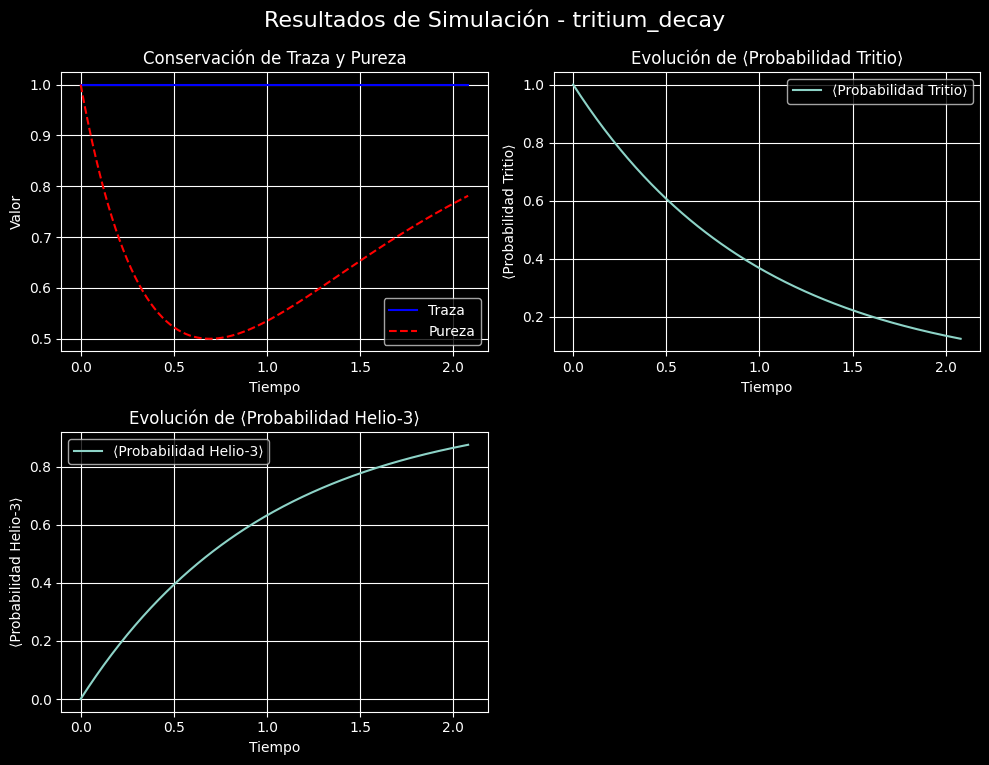


4. Simulando Láser de 4 niveles...
   ✓ Simulación exitosa (2918 evaluaciones)


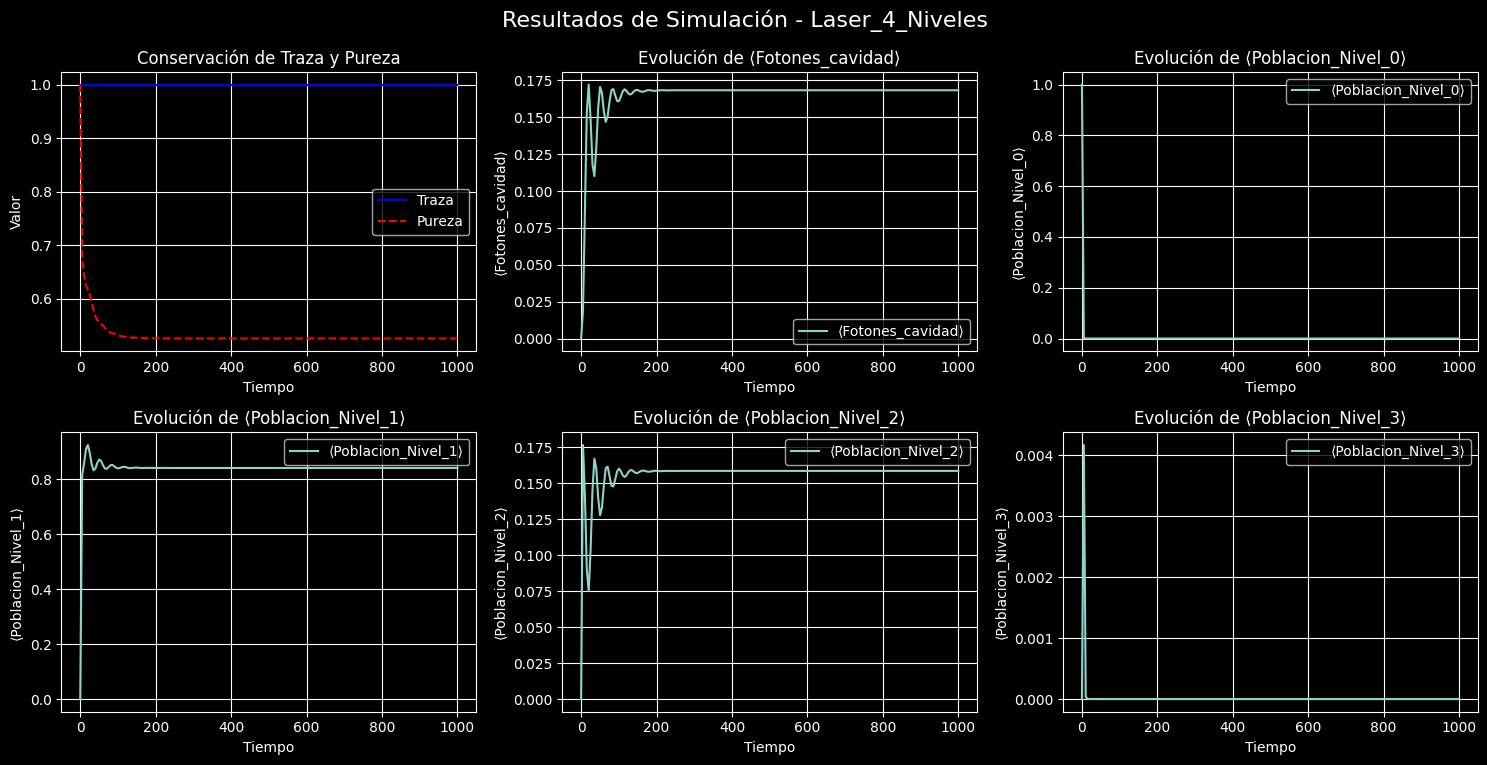


ANÁLISIS DE UMBRAL DE LÁSER
   • Simulando para bombeo = 0.010 (1/15)
   • Simulando para bombeo = 0.116 (2/15)
   • Simulando para bombeo = 0.223 (3/15)
   • Simulando para bombeo = 0.329 (4/15)
   • Simulando para bombeo = 0.436 (5/15)
   • Simulando para bombeo = 0.542 (6/15)
   • Simulando para bombeo = 0.649 (7/15)
   • Simulando para bombeo = 0.755 (8/15)
   • Simulando para bombeo = 0.861 (9/15)
   • Simulando para bombeo = 0.968 (10/15)
   • Simulando para bombeo = 1.074 (11/15)
   • Simulando para bombeo = 1.181 (12/15)
   • Simulando para bombeo = 1.287 (13/15)
   • Simulando para bombeo = 1.394 (14/15)
   • Simulando para bombeo = 1.500 (15/15)


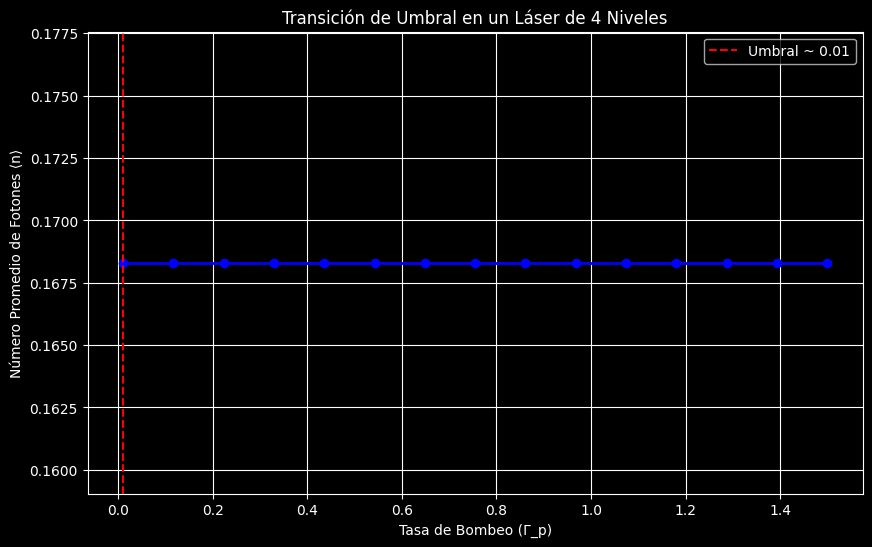


=== Simulaciones completas ===


In [4]:
# -*- coding: utf-8 -*-
"""
Script robusto de Python para implementar el formalismo de la ecuación de Lindblad
para simular la dinámica de la matriz de densidad de un sistema cuántico.

Principales Caracteristicas:
- Validación robusta de parámetros de entrada
- Manejo de errores y excepciones
- Logging para debugging y seguimiento
- Configuración flexible de parámetros
- Métodos de análisis avanzados
- Guardado/carga de resultados
- Visualizaciones mejoradas
- Documentación completa

Autor: Jacobo Tlacaelel Mina Rodriguez
Edición y verificacion de la Versión: Gemini Ai
Fecha: 2025
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import logging
import warnings
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Dict, Union
import pickle
import json
from pathlib import Path

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('lindblad_simulation.log'),
        plt.matplotlib.backends.backend_agg.FigureCanvasAgg # Add this line
        # logging.StreamHandler() # Comment or remove this line if you prefer to log to file only
    ]
)
logger = logging.getLogger(__name__)

# Configuraciones por defecto
@dataclass
class SimulationConfig:
    """Configuración para las simulaciones de Lindblad."""
    rtol: float = 1e-8
    atol: float = 1e-10
    max_step: Optional[float] = None
    method: str = 'RK45'
    dense_output: bool = False

    def validate(self):
        """Valida la configuración."""
        if self.rtol <= 0 or self.atol <= 0:
            raise ValueError("Las tolerancias deben ser positivas")
        if self.method not in ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']:
            raise ValueError(f"Método {self.method} no soportado")

@dataclass
class SystemParameters:
    """Parámetros base del sistema cuántico."""
    name: str
    dimension: int
    H: np.ndarray
    L_operators: List[np.ndarray]
    rho_0: np.ndarray
    t_span: Tuple[float, float]
    observables: Dict[str, np.ndarray] = field(default_factory=dict)

    def __post_init__(self):
        self.validate()

    def validate(self):
        """Valida todos los parámetros del sistema."""
        # Validar dimensiones
        if self.dimension <= -1:
            raise ValueError("La dimensión debe ser positiva")

        # Validar Hamiltoniano
        if self.H.shape != (self.dimension, self.dimension):
            raise ValueError(f"Hamiltoniano debe ser {self.dimension}x{self.dimension}")

        if not np.allclose(self.H, self.H.conj().T):
            warnings.warn("El Hamiltoniano no es Hermitiano", UserWarning)

        # Validar operadores de Lindblad
        for i, L in enumerate(self.L_operators):
            if L.shape != (self.dimension, self.dimension):
                raise ValueError(f"Operador Lindblad {i} debe ser {self.dimension}x{self.dimension}")

        # Validar matriz de densidad inicial
        if self.rho_0.shape != (self.dimension, self.dimension):
            raise ValueError(f"Matriz de densidad inicial debe ser {self.dimension}x{self.dimension}")

        if not np.allclose(self.rho_0, self.rho_0.conj().T):
            warnings.warn("La matriz de densidad inicial no es Hermitiana", UserWarning)

        trace = np.trace(self.rho_0)
        if not np.isclose(trace, 1.0):
            warnings.warn(f"La traza de rho_0 es {trace:.6f}, no 1.0", UserWarning)

        # Verificar que rho_0 es semidefinida positiva
        eigenvals = np.linalg.eigvals(self.rho_0)
        if np.any(eigenvals < -1e-10):
            warnings.warn("La matriz de densidad inicial no es semidefinida positiva", UserWarning)

        # Validar span de tiempo
        if self.t_span[1] <= self.t_span[0]:
            raise ValueError("El tiempo final debe ser mayor que el inicial")

# Nuevo dataclass para Cavity QED
@dataclass
class CavityQEDParameters:
    omega_a: float  # Frecuencia atómica
    omega_c: float  # Frecuencia de la cavidad
    g: float        # Constante de acoplamiento (frecuencia de Rabi)
    gamma: float    # Tasa de decaimiento atómico
    kappa: float    # Tasa de decaimiento de la cavidad
    N_max: int      # Número máximo de fotones de la cavidad (dimensión de Fock)
    N_atoms: int = 1 # Número de átomos (1 para Jaynes-Cummings)

    @property
    def cooperativity(self) -> float:
        """C = g^2 / (kappa * gamma)"""
        if self.kappa * self.gamma == 0:
            return float('inf')
        return (self.g**2) / (self.kappa * self.gamma)

    @property
    def purcell_factor(self) -> float:
        """Factor de Purcell = C para resonancia"""
        return self.cooperativity

    @property
    def coupling_regime(self) -> str:
        """Clasifica el régimen de acoplamiento"""
        if self.g > self.kappa and self.g > self.gamma:
            return "Fuerte"
        elif self.g < self.kappa and self.g < self.gamma:
            return "Débil"
        elif self.g > self.kappa and self.g < self.gamma:
            return "Mala Cavidad"
        elif self.g < self.kappa and self.g > self.gamma:
            return "Mal Átomo"
        return "Transición"


class LindladSimulator:
    """Simulador robusto para la ecuación de Lindblad."""

    def __init__(self, config: Optional[SimulationConfig] = None):
        """
        Inicializa el simulador.

        Args:
            config: Configuración de la simulación
        """
        self.config = config if config is not None else SimulationConfig()
        self.config.validate()
        self.results = {}
        logger.info("Simulador Lindblad inicializado")

    def lindblad_rhs(self, t: float, rho_vec: np.ndarray,
                    H: np.ndarray, L_operators: List[np.ndarray]) -> np.ndarray:
        """
        Función que define el lado derecho de la ecuación de Lindblad.

        Args:
            t: El tiempo actual
            rho_vec: La matriz de densidad aplanada (vectorizada)
            H: El Hamiltoniano del sistema
            L_operators: Lista de operadores de Lindblad

        Returns:
            El vector aplanado de la derivada de la matriz de densidad
        """
        try:
            # Desvectorizar la matriz de densidad
            n = int(np.sqrt(len(rho_vec)))
            rho = rho_vec.reshape((n, n))

            # Término de evolución coherente
            drho_dt = -1j * (H @ rho - rho @ H)

            # Términos de decoherencia (superoperador de disipación)
            for L in L_operators:
                L_dagger = L.conj().T
                drho_dt += (L @ rho @ L_dagger) - 0.5 * (L_dagger @ L @ rho + rho @ L_dagger @ L)

            return drho_dt.flatten()

        except Exception as e:
            logger.error(f"Error en lindblad_rhs en t={t}: {e}")
            raise

    def simulate(self, params: SystemParameters,
                t_eval: Optional[np.ndarray] = None) -> Dict:
        """
        Ejecuta la simulación de Lindblad.

        Args:
            params: Parámetros del sistema
            t_eval: Puntos de tiempo para evaluación

        Returns:
            Diccionario con los resultados
        """
        logger.info(f"Iniciando simulación para sistema: {params.name}")

        # Configurar puntos de evaluación
        if t_eval is None:
            t_eval = np.linspace(params.t_span[0], params.t_span[1], 100)

        try:
            # Resolver la ecuación diferencial
            solve_ivp_args = {
                'fun': self.lindblad_rhs,
                't_span': params.t_span,
                'y0': params.rho_0.flatten(),
                'args': (params.H, params.L_operators),
                't_eval': t_eval,
                'rtol': self.config.rtol,
                'atol': self.config.atol,
                'method': self.config.method,
                'dense_output': self.config.dense_output
            }

            if self.config.max_step is not None:
                solve_ivp_args['max_step'] = self.config.max_step

            sol = solve_ivp(**solve_ivp_args)


            if not sol.success:
                raise RuntimeError(f"Integración falló: {sol.message}")

            # Procesar resultados
            rho_t = np.array([s.reshape((params.dimension, params.dimension))
                            for s in sol.y.T])

            # Calcular observables
            observables = {}
            for obs_name, obs_op in params.observables.items():
                observables[obs_name] = [np.trace(rho @ obs_op) for rho in rho_t]

            # Métricas de calidad
            traces = [np.trace(rho).real for rho in rho_t]
            purities = [np.trace(rho @ rho).real for rho in rho_t]

            results = {
                'success': True,
                'name': params.name, # Include system name here
                'time': sol.t,
                'rho_t': rho_t,
                'observables': observables,
                'traces': traces,
                'purities': purities,
                'integration_info': {
                    'nfev': sol.nfev,
                    'njev': sol.njev,
                    'nlu': sol.nlu,
                    'status': sol.status,
                    'message': sol.message
                }
            }

            self.results[params.name] = results
            logger.info(f"Simulación completada para {params.name}")

            # Verificar conservación de la traza
            trace_variation = max(traces) - min(traces)
            if trace_variation > 1e-6:
                warnings.warn(f"Variación de traza: {trace_variation:.2e}")

            return results

        except Exception as e:
            logger.error(f"Error en simulación de {params.name}: {e}")
            return {'success': False, 'error': str(e)}

    def save_results(self, filename: str, format: str = 'pickle'):
        """
        Guarda los resultados de simulación.

        Args:
            filename: Nombre del archivo
            format: Formato ('pickle' o 'json')
        """
        try:
            if format == 'pickle':
                with open(filename, 'wb') as f:
                    pickle.dump(self.results, f)
            elif format == 'json':
                # Convertir arrays numpy para JSON
                json_results = {}
                for name, result in self.results.items():
                    if result.get('success', False):
                        json_results[name] = {
                            'time': result['time'].tolist(),
                            'traces': result['traces'],
                            'purities': result['purities'],
                            'observables': {k: np.real(v).tolist()
                                          for k, v in result['observables'].items()}
                        }
                with open(filename, 'w') as f:
                    json.dump(json_results, f, indent=2)

            logger.info(f"Resultados guardados en {filename}")
        except Exception as e:
            logger.error(f"Error guardando resultados: {e}")

    def load_results(self, filename: str, format: str = 'pickle'):
        """Carga resultados previamente guardados."""
        try:
            if format == 'pickle':
                with open(filename, 'rb') as f:
                    self.results = pickle.load(f)
            elif format == 'json':
                with open(filename, 'r') as f:
                    self.results = json.load(f)

            logger.info(f"Resultados cargados desde {filename}")
        except Exception as e:
            logger.error(f"Error cargando resultados: {e}")

def create_qubit_system() -> SystemParameters:
    """Crea un sistema de qubit con relajación T1."""

    # Parámetros del sistema
    omega_0 = 1.0
    gamma_t1 = 0.1

    # Operadores
    H_qubit = 0.5 * omega_0 * np.array([[1, 0], [0, -1]], dtype=complex)
    sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
    L_qubit = [np.sqrt(gamma_t1) * sigma_minus]

    # Estado inicial
    rho_0_qubit = np.array([[0, 0], [0, 1]], dtype=complex)

    # Observables
    observables = {
        'sigma_z': np.array([[1, 0], [0, -1]], dtype=complex),
        'sigma_x': np.array([[0, 1], [1, 0]], dtype=complex),
        'sigma_y': np.array([[0, -1j], [1j, 0]], dtype=complex)
    }

    return SystemParameters(
        name="qubit_T1",
        dimension=2,
        H=H_qubit,
        L_operators=L_qubit,
        rho_0=rho_0_qubit,
        t_span=(0, 10 / gamma_t1),
        observables=observables
    )

def create_oscillator_system(N: int = 5) -> SystemParameters:
    """Crea un sistema de oscilador armónico con dephasing."""

    # Parámetros del sistema
    omega_osc = 1.0
    gamma_deph = 0.5

    # Operadores
    a = np.diag(np.sqrt(np.arange(1, N)), k=1).astype(complex)
    adagger = a.conj().T
    H_osc = omega_osc * (adagger @ a)

    # Operador de dephasing
    P = np.diag([(-1)**n for n in range(N)]).astype(complex)
    L_osc = [np.sqrt(gamma_deph) * P]

    # Estado inicial: superposición
    psi_0 = np.zeros(N, dtype=complex)
    psi_0[0] = 1/np.sqrt(2)
    psi_0[1] = 1/np.sqrt(2)
    rho_0_osc = np.outer(psi_0, psi_0.conj())

    # Observables
    n_op = adagger @ a
    x_op = (a + adagger) / np.sqrt(2)
    p_op = -1j * (a - adagger) / np.sqrt(2)

    observables = {
        'number': n_op,
        'position': x_op,
        'momentum': p_op
    }

    return SystemParameters(
        name="oscillator_dephasing",
        dimension=N,
        H=H_osc,
        L_operators=L_osc,
        rho_0=rho_0_osc,
        t_span=(0, 5 / gamma_deph),
        observables=observables
    )

def create_tritium_decay_system() -> SystemParameters:
    """
    Crea un sistema cuántico para modelar el decaimiento beta del tritio a helio-3.
    """
    # Constantes físicas
    T_HALF_YEARS = 12.32  # Vida media del tritio en años
    T_HALF_SEC = T_HALF_YEARS * 365.25 * 24 * 3600  # en segundos

    # Tasa de decaimiento (gamma)
    gamma = np.log(2) / T_HALF_SEC

    # Para la simulación, es más fácil usar unidades de tiempo normalizadas.
    # Usemos gamma = 1.0. Esto significa que el tiempo de la simulación
    # estará en unidades de la vida media / ln(2).
    # O podemos mantener gamma real y simular en segundos. Vamos a normalizar.

    gamma_norm = 1.0 # Tasa de decaimiento normalizada

    # Definimos los estados base
    # |Tritio> = [1, 0]^T
    # |Helio-3> = [0, 1]^T

    # El Hamiltoniano es trivial si solo nos interesa el decaimiento.
    # La diferencia de energía está implícita en el proceso de decaimiento.
    H_decay = np.array([[0, 0], [0, 0]], dtype=complex)

    # El operador de Lindblad modela la transición T -> He3.
    # Es un operador de "descenso" de Tritio a Helio-3.
    sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
    L_operators_decay = [np.sqrt(gamma_norm) * sigma_minus]

    # Estado inicial: Tritio puro
    rho_0_decay = np.array([[1, 0], [0, 0]], dtype=complex)

    # Observables: Probabilidad de estar en cada estado
    P_tritium = np.array([[1, 0], [0, 0]], dtype=complex)
    P_helium3 = np.array([[0, 0], [0, 1]], dtype=complex)

    observables = {
        'Probabilidad Tritio': P_tritium,
        'Probabilidad Helio-3': P_helium3
    }

    # El tiempo de simulación debe ser de varias vidas medias para ver el efecto.
    # Si gamma_norm = 1.0, el tiempo t=1 es una vida media / ln(2).
    # La vida media ocurre en t = ln(2) ~= 0.693.
    # Simulemos por 3 vidas medias.
    t_end = 3 * np.log(2) / gamma_norm # Corresponde a 3 vidas medias

    return SystemParameters(
        name="tritium_decay",
        dimension=2,
        H=H_decay,
        L_operators=L_operators_decay,
        rho_0=rho_0_decay,
        t_span=(0, t_end),
        observables=observables
    )

def create_four_level_laser_system(dim_atom: int = 4, dim_cavity: int = 5,
                                   omega_atom: float = 1.0, omega_cavity: float = 1.0,
                                   g: float = 0.1, kappa: float = 0.05,
                                   pump_rate: float = 0.2, gamma_32: float = 1.0,
                                   gamma_10: float = 1.0, gamma_21: float = 0.01) -> SystemParameters:
    """
    Crea un sistema cuántico para modelar un láser simple de 4 niveles
    acoplado a un modo de cavidad con parámetros personalizables.
    """
    # ---- Parámetros del Sistema ----
    # Usar parámetros pasados como argumentos
    omega_atom = 1.0  # Frecuencia de las transiciones atómicas (normalizada)
    omega_cavity = 1.0 # Frecuencia de la cavidad (resonante con la transición láser)
    g = 0.1 # Constante de acoplamiento átomo-cavidad

    kappa = 0.05 # Tasa de pérdida de fotones de la cavidad
    pump_rate = 0.2 # Tasa de bombeo al nivel 3
    gamma_32 = 1.0 # Tasa de decaimiento rápido 3 -> 2
    gamma_10 = 1.0 # Tasa de decaimiento rápido 1 -> 0
    gamma_21 = 0.01 # Tasa de emisión espontánea 2 -> 1 (transición láser)

    # ---- Operadores Base ----
    # Espacio de Hilbert combinado: H_atom x H_cavity
    dimension = dim_atom * dim_cavity

    # Operadores atómicos (en el espacio del átomo, luego se expanden)
    sigma_01 = np.zeros((dim_atom, dim_atom), dtype=complex)
    sigma_12 = np.zeros((dim_atom, dim_atom), dtype=complex)
    sigma_23 = np.zeros((dim_atom, dim_atom), dtype=complex)
    sigma_30 = np.zeros((dim_atom, dim_atom), dtype=complex)

    sigma_01[0, 1] = 1
    sigma_12[1, 2] = 1
    sigma_23[2, 3] = 1
    sigma_30[3, 0] = 1

    # Proyectores en los niveles atómicos
    P_atom = [np.zeros((dim_atom, dim_atom), dtype=complex) for _ in range(dim_atom)]
    for i in range(dim_atom):
        P_atom[i][i, i] = 1

    # Operadores de cavidad (en el espacio de la cavidad, luego se expanden)
    a = np.diag(np.sqrt(np.arange(1, dim_cavity)), k=1).astype(complex)
    adagger = a.conj().T
    n_op_cavity = adagger @ a

    # Expandir operadores al espacio de Hilbert combinado (producto tensorial)
    I_atom = np.eye(dim_atom)
    I_cavity = np.eye(dim_cavity)

    # Operadores atómicos en el espacio combinado
    sigma_01_full = np.kron(sigma_01, I_cavity)
    sigma_12_full = np.kron(sigma_12, I_cavity)
    sigma_23_full = np.kron(sigma_23, I_cavity)
    sigma_30_full = np.kron(sigma_30, I_cavity)

    # Proyectores atómicos en el espacio combinado
    P_atom_full = [np.kron(P, I_cavity) for P in P_atom]

    # Operadores de cavidad en el espacio combinado
    a_full = np.kron(I_atom, a)
    adagger_full = np.kron(I_atom, adagger)
    n_op = np.kron(I_atom, n_op_cavity) # Operador número total de fotones

    # ---- Hamiltoniano ----
    # H = H_atom + H_cavity + H_interaction
    # H_atom con energías de los niveles atómicos
    H_atom = np.diag([0, omega_atom, 2*omega_atom, 3*omega_atom]).astype(complex) # Ejemplo de energías
    H_cavity = omega_cavity * n_op_cavity

    # Interacción resonante 1 <-> 2
    # Asegurarse de usar los operadores expandidos
    H_interaction_full = 1j * g * (sigma_12_full @ adagger_full - sigma_12_full.conj().T @ a_full)

    H_laser = np.kron(H_atom, I_cavity) + np.kron(I_atom, H_cavity) + H_interaction_full

    # ---- Operadores de Lindblad (Disipación y Bombeo) ----
    L_operators = []

    # 1. Pérdida de fotones de la cavidad (el haz del láser)
    L_cavity_loss = np.sqrt(kappa) * a_full
    L_operators.append(L_cavity_loss)

    # 2. Bombeo incoherente de |0> a |3>
    L_pump = np.sqrt(pump_rate) * sigma_30_full
    L_operators.append(L_pump)

    # 3. Decaimiento rápido 3 -> 2
    L_decay_32 = np.sqrt(gamma_32) * sigma_23_full
    L_operators.append(L_decay_32)

    # 4. Decaimiento rápido 1 -> 0
    L_decay_10 = np.sqrt(gamma_10) * sigma_01_full.conj().T # sigma_01.dag() es sigma_10
    L_operators.append(L_decay_10)

    # 5. Emisión espontánea indeseada en la transición láser 2 -> 1
    L_spontaneous_21 = np.sqrt(gamma_21) * sigma_12_full.conj().T # sigma_12.dag() es sigma_21
    L_operators.append(L_spontaneous_21)

    # ---- Estado Inicial ----
    # Empezamos con el átomo en el estado fundamental y la cavidad vacía.
    rho_atom_0 = np.zeros((dim_atom, dim_atom))
    rho_atom_0[0, 0] = 1.0
    rho_cavity_0 = np.zeros((dim_cavity, dim_cavity))
    rho_cavity_0[0, 0] = 1.0
    rho_0_laser = np.kron(rho_atom_0, rho_cavity_0).astype(complex)

    # ---- Observables ----
    observables = {
        'Fotones_cavidad': n_op,
        'Poblacion_Nivel_0': P_atom_full[0],
        'Poblacion_Nivel_1': P_atom_full[1],
        'Poblacion_Nivel_2': P_atom_full[2],
        'Poblacion_Nivel_3': P_atom_full[3],
    }

    return SystemParameters(
        name="Laser_4_Niveles",
        dimension=dimension,
        H=H_laser,
        L_operators=L_operators,
        rho_0=rho_0_laser,
        t_span=(0, 50 / kappa), # Simular por varias vidas medias de la cavidad
        observables=observables
    )


def plot_results(results: Dict, save_path: Optional[str] = None):
    """
    Visualiza los resultados de la simulación con un fondo oscuro.

    Args:
        results: Resultados de simulación.
        save_path: Ruta para guardar las figuras.
    """
    if not results.get('success', False):
        logger.error("No se pueden graficar resultados fallidos")
        return

    logger.info("Iniciando graficación de resultados en tema oscuro.")

    # Usar el estilo 'dark_background' para un fondo negro y un mejor contraste.
    plt.style.use('dark_background')

    # Extraer datos
    time = results['time']
    observables = results['observables']
    num_observables = len(observables)
    total_plots = num_observables + 1  # +1 para la traza y la pureza

    # Determinar el tamaño de la cuadrícula para los subplots
    cols = int(np.ceil(np.sqrt(total_plots)))
    rows = int(np.ceil(total_plots / cols))

    # Crear la figura y los subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten() # Aplanar para facilitar la iteración

    # Graficar Traza y Pureza
    axes[0].plot(time, results['traces'], 'b-', label='Traza')
    axes[0].plot(time, results['purities'], 'r--', label='Pureza')
    axes[0].set_xlabel('Tiempo')
    axes[0].set_ylabel('Valor')
    axes[0].set_title('Conservación de Traza y Pureza')
    axes[0].legend()
    axes[0].grid(True)

    # Graficar Observables
    for i, (obs_name, obs_vals) in enumerate(observables.items()):
        axes[i + 1].plot(time, np.real(obs_vals), label=f'⟨{obs_name}⟩')
        axes[i + 1].set_xlabel('Tiempo')
        axes[i + 1].set_ylabel(f'⟨{obs_name}⟩')
        axes[i + 1].set_title(f'Evolución de ⟨{obs_name}⟩')
        axes[i + 1].legend()
        axes[i + 1].grid(True)

    # Ocultar cualquier subplot no utilizado
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(f'Resultados de Simulación - {results["name"]}', fontsize=16)
    plt.show()


def demonstrate_laser_threshold():
    print("\n" + "="*60)
    print("ANÁLISIS DE UMBRAL DE LÁSER")
    print("="*60)

    config = SimulationConfig(rtol=1e-7, atol=1e-9) # Ajustar tolerancias para sistemas más grandes
    simulator = LindladSimulator(config)

    # Parámetros fijos
    N_max = 10
    g = 1.0
    kappa = 0.2

    # Barrido de la tasa de bombeo
    pump_values = np.linspace(0.01, 1.5, 15)
    steady_state_photons = []

    for i, pump in enumerate(pump_values):
        print(f"   • Simulando para bombeo = {pump:.3f} ({i+1}/{len(pump_values)})")

        laser_system = create_four_level_laser_system(
            dim_cavity=N_max, g=g, kappa=kappa, pump_rate=pump
        )
        results = simulator.simulate(laser_system)

        if results['success']:
            # Extraer el número de fotones en estado estacionario
            photons = np.real(results['observables']['Fotones_cavidad'])
            # Promediar el último 20% del tiempo
            ss_photons = np.mean(photons[int(0.8 * len(photons)):])
            steady_state_photons.append(ss_photons)
        else:
            steady_state_photons.append(np.nan) # Marcar como fallido

    # Graficar la curva de umbral del láser
    plt.figure(figsize=(10, 6))
    plt.plot(pump_values, steady_state_photons, 'bo-', linewidth=2)
    plt.xlabel('Tasa de Bombeo (Γ_p)')
    plt.ylabel('Número Promedio de Fotones ⟨n⟩')
    plt.title('Transición de Umbral en un Láser de 4 Niveles')
    plt.grid(True)

    # Encontrar el umbral (donde la curva cambia de pendiente)
    diffs = np.diff(steady_state_photons)
    if len(diffs) > 1:
        try:
            # Find the index where the difference is maximized, often indicates threshold
            threshold_idx = np.nanargmax(diffs)
            threshold_pump = pump_values[threshold_idx]
            plt.axvline(threshold_pump, color='r', linestyle='--', label=f'Umbral ~ {threshold_pump:.2f}')
            plt.legend()
        except ValueError: # Ocurre si hay NaNs o diffs está vacío
            print("No se pudo determinar el umbral debido a errores en la simulación o datos insuficientes.")

    plt.show()


def main():
    """Función principal de demostración."""
    print("=== Simulador Robusto de Ecuación de Lindblad ===\n")

    # Configuración de simulación
    config = SimulationConfig(rtol=1e-8, atol=1e-10)
    simulator = LindladSimulator(config)

    # Ejemplo 1: Qubit con relajación T1
    print("1. Simulando qubit con relajación T1...")
    qubit_params = create_qubit_system()
    t_eval_qubit = np.linspace(0, qubit_params.t_span[1], 200)

    results_qubit = simulator.simulate(qubit_params, t_eval_qubit)
    if results_qubit['success']:
        print(f"   ✓ Simulación exitosa ({results_qubit['integration_info']['nfev']} evaluaciones)")
        plot_results(results_qubit)
    else:
        print(f"   ✗ Error: {results_qubit['error']}")

    # Ejemplo 2: Oscilador con dephasing
    print("\n2. Simulando oscilador armónico con dephasing...")
    osc_params = create_oscillator_system(N=6)
    t_eval_osc = np.linspace(0, osc_params.t_span[1], 200)

    results_osc = simulator.simulate(osc_params, t_eval_osc)
    if results_osc['success']:
        print(f"   ✓ Simulación exitosa ({results_osc['integration_info']['nfev']} evaluaciones)")

        # Gráfico especial para coherencia
        plt.figure(figsize=(8, 6))
        coherence = [np.abs(rho[0, 1]) for rho in results_osc['rho_t']]
        plt.plot(results_osc['time'], coherence, 'b-', linewidth=2)
        plt.title('Decaimiento de Coherencia |ρ₀₁| por Dephasing')
        plt.xlabel('Tiempo')
        plt.ylabel('|ρ₀₁|')
        plt.grid(True)
        plt.show()

        plot_results(results_osc)
    else:
        print(f"   ✗ Error: {results_osc['error']}")

    # Ejemplo 3: Decaimiento de Tritio
    print("\n3. Simulando decaimiento de Tritio...")
    tritium_params = create_tritium_decay_system()
    t_eval_tritium = np.linspace(0, tritium_params.t_span[1], 200)

    results_tritium = simulator.simulate(tritium_params, t_eval_tritium)
    if results_tritium['success']:
        print(f"   ✓ Simulación exitosa ({results_tritium['integration_info']['nfev']} evaluaciones)")
        plot_results(results_tritium)
    else:
        print(f"   ✗ Error: {results_tritium['error']}")

    # Ejemplo 4: Láser de 4 niveles
    print("\n4. Simulando Láser de 4 niveles...")
    laser_params = create_four_level_laser_system()
    t_eval_laser = np.linspace(0, laser_params.t_span[1], 200)

    results_laser = simulator.simulate(laser_params, t_eval_laser)
    if results_laser['success']:
        print(f"   ✓ Simulación exitosa ({results_laser['integration_info']['nfev']} evaluaciones)")
        plot_results(results_laser)
    else:
        print(f"   ✗ Error: {results_laser['error']}")

    # Demostración del umbral del láser
    demonstrate_laser_threshold()


    # Guardar resultados
    simulator.save_results('simulacion_lindblad.pkl')
    simulator.save_results('simulacion_lindblad.json', format='json')

    print("\n=== Simulaciones completas ===")

if __name__ == "__main__":
    main()